# Research question 2

#### 2. How often do users visit each other? Does it depend on whether they live in a city or not or on the season of the year?

### Concept

- for each user, check for friends check-ins in check-ins compared 

### Libraries

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from poisson_etest import poisson_etest
from sklearn.linear_model import LinearRegression
from geopy.distance import distance
from functions import load_data
from obspy.geodetics import degrees2kilometers

### Data

In [145]:
%cd "/home/mogan/Desktop"
bk_checkins, bk_edges = load_data("Brightkite")
gw_checkins, gw_edges = load_data("Gowalla")

/home/mogan/Desktop


In [146]:
# Since the computations are quite heavy, take a representative subset 
# (Jupyter crashes for the whole datasets for my computer)
n = 10000
bk_checkins = bk_checkins.head(n)#sample(n, random_state=23)
gw_checkins = gw_checkins.head(n)#sample(n, random_state=23)

In [147]:
# Preprocess the data
bk_checkins = bk_checkins[(bk_checkins.latitude < 90) & (bk_checkins.latitude > -90)]
gw_checkins = gw_checkins[(gw_checkins.latitude < 90) & (gw_checkins.latitude > -90)]
bk_checkins = bk_checkins.loc[~((bk_checkins['latitude'] == 0) & (bk_checkins['longitude'] == 0))]

In [148]:
## 2. Discretise the world
# How many degrees are 25 kilometers?
km_25 = 25 / degrees2kilometers(1)

bk_checkins[['check_in_lat', 'check_in_long']] = bk_checkins.loc[:, ["latitude", "longitude"]].div(km_25, axis=1).astype('int').mul(km_25)
bk_checkins['cell'] = bk_checkins.apply(lambda x: (x['check_in_lat'], x['check_in_long']), axis = 1)
gw_checkins[['check_in_lat', 'check_in_long']] = bk_checkins.loc[:, ["latitude", "longitude"]].div(km_25, axis=1).astype('int').mul(km_25)
gw_checkins['cell'] = gw_checkins.apply(lambda x: (x['check_in_lat'], x['check_in_long']), axis = 1)

In [149]:
## 3. Compute home location
bk_loc_count = bk_checkins.groupby(by = ['user_id', 'cell'], as_index = False).count()
bk_most_checked_in_locations = bk_loc_count.sort_values('latitude', ascending=False).drop_duplicates(['user_id']).sort_values('user_id').set_index('user_id')['cell']
gw_loc_count = gw_checkins.groupby(by = ['user_id', 'cell'], as_index = False).count()
gw_most_checked_in_locations = gw_loc_count.sort_values('latitude', ascending=False).drop_duplicates(['user_id']).sort_values('user_id').set_index('user_id')['cell']

bk_checkins_temp = bk_checkins.copy().set_index('user_id')
bk_home_locs = bk_checkins_temp.merge(bk_most_checked_in_locations, left_index = True, right_index = True)
bk_home_locs = bk_home_locs[bk_home_locs.cell_x == bk_home_locs.cell_y].groupby('user_id')[['latitude','longitude']].agg('mean')
bk_home_locs['location'] = list(zip(bk_home_locs.latitude, bk_home_locs.longitude))
gw_checkins_temp = gw_checkins.copy().set_index('user_id')
gw_home_locs = gw_checkins_temp.merge(gw_most_checked_in_locations, left_index = True, right_index = True)
gw_home_locs = gw_home_locs[gw_home_locs.cell_x == gw_home_locs.cell_y].groupby('user_id')[['latitude','longitude']].agg('mean')
gw_home_locs['location'] = list(zip(gw_home_locs.latitude, gw_home_locs.longitude))  

In [150]:
# Make a unique index for every check in, because there is no other unique variable
bk_checkins['check-in'] = bk_checkins.index
gw_checkins['check-in'] = gw_checkins.index

In [151]:
# Add home location for friend A
bk_checkins = bk_checkins.merge(bk_home_locs['location'], left_on = 'user_id', right_index = True).rename(columns = {'location': 'home_location'})
gw_checkins = gw_checkins.merge(gw_home_locs['location'], left_on = 'user_id', right_index = True).rename(columns = {'location': 'home_location'})

In [152]:
# Merge check-in data with the friend network dataframe
bk_checkins_merged = bk_checkins.merge(bk_edges, left_on = 'user_id', right_on = 'from_id').drop(columns = ['from_id'], axis = 1)
gw_checkins_merged = gw_checkins.merge(gw_edges, left_on = 'user_id', right_on = 'from_id').drop(columns = ['from_id'], axis = 1)

# Add each friend's B home location to the extended dataframe
bk_checkins_merged = bk_checkins_merged.merge(bk_home_locs, left_on = "to_id", right_index = True).drop(columns=['location'], axis = 1)
gw_checkins_merged = gw_checkins_merged.merge(gw_home_locs, left_on = "to_id", right_index = True).drop(columns=['location'], axis = 1)

In [153]:
bk_checkins_merged

,user_id,checkin_time,latitude_x,longitude_x,location_id,check_in_lat,check_in_long,cell,check-in,home_location,to_id,latitude_y,longitude_y
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5,39.570151,-104.770967,"(39.57015066042415, -104.7709670895321)",0,"(39.74758051422567, -104.96297404320383)",1,37.603702,-122.383366
120,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2,39.794981,-104.995797,"(39.794981061903826, -104.9957974910118)",1,"(39.74758051422567, -104.96297404320383)",1,37.603702,-122.383366
240,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79,39.794981,-104.995797,"(39.794981061903826, -104.9957974910118)",2,"(39.74758051422567, -104.96297404320383)",1,37.603702,-122.383366
360,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683,39.570151,-104.995797,"(39.57015066042415, -104.9957974910118)",3,"(39.74758051422567, -104.96297404320383)",1,37.603702,-122.383366
480,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc,39.570151,-104.995797,"(39.57015066042415, -104.9957974910118)",4,"(39.74758051422567, -104.96297404320383)",1,37.603702,-122.383366
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211863,7,2009-11-12T02:27:01Z,34.014676,-118.494960,a53ae51af4df300eaf0c99d7fd650e0f9703c32b,33.949391,-118.485622,"(33.94939062343208, -118.48562157979275)",9995,"(37.586887345454464, -122.35431428686843)",0,39.747581,-104.962974
1212093,7,2009-11-11T23:02:35Z,34.413329,-119.860972,ee75c1dea22411dda27d536123c3101a,34.399051,-119.834604,"(34.399051426391445, -119.83460398867085)",9996,"(37.586887345454464, -122.35431428686843)",0,39.747581,-104.962974
1212323,7,2009-11-11T21:59:25Z,34.413177,-119.856454,cbcf613ac726ef406a668cf4dda22639,34.399051,-119.834604,"(34.399051426391445, -119.83460398867085)",9997,"(37.586887345454464, -122.35431428686843)",0,39.747581,-104.962974
1212553,7,2009-11-11T17:01:32Z,37.618889,-122.375000,45a01a2904c944777766a2bf76f5948e,37.546677,-122.307738,"(37.546677047107, -122.30773840494736)",9998,"(37.586887345454464, -122.35431428686843)",0,39.747581,-104.962974


In [154]:
# Calculate the distance between check-ins and friends home
bk_checkins_merged['distances_to_friend'] = bk_checkins_merged.apply(lambda x: distance((x['latitude_x'], x['longitude_x']), (x['latitude_y'], x['longitude_y'])).km, axis = 1)
gw_checkins_merged['distances_to_friend'] = gw_checkins_merged.apply(lambda x: distance((x['latitude_x'], x['longitude_x']), (x['latitude_y'], x['longitude_y'])).km, axis = 1)

In [155]:
# Investigate if a check-in was a friends visit or not 
# by grouping by check-in id's and checking if any distance is smaller than r
radius = 25
bk_friend_visited = bk_checkins_merged.groupby("check-in").apply(lambda x: (x['distances_to_friend'] < radius).any()).to_frame()
gw_friend_visited = gw_checkins_merged.groupby("check-in").apply(lambda x: (x['distances_to_friend'] < radius).any()).to_frame()

In [156]:
bk_checkins_merged['visited_friend'] = bk_checkins_merged.apply(lambda x: (x['distances_to_friend'] < radius), axis = 1)
gw_checkins_merged['visited_friend'] = gw_checkins_merged.apply(lambda x: (x['distances_to_friend'] < radius), axis = 1)

### How often do friends visit each other?

In [157]:
bk_friend_visited = bk_checkins_merged[bk_checkins_merged['visited_friend'] == True].groupby(['user_id','to_id']).count().iloc[:,:1]
gw_friend_visited = gw_checkins_merged[gw_checkins_merged['visited_friend'] == True].groupby(['user_id','to_id']).count().iloc[:,:1]


In [158]:
bk_friend_visited['data'] = 'Brightkite'
gw_friend_visited['data'] = 'Gowalla'

bk_gw_friends = bk_friend_visited.append(gw_friend_visited)
#gw_friend_visited.head()

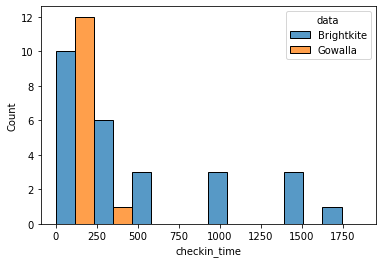

In [164]:
sns.histplot(data = bk_gw_friends, x = 'checkin_time', hue = 'data', multiple="dodge");

In [18]:
# Intermediately save the dataframes
#bk_checkins_merged.to_pickle("B_checkins_merged.pickle")
#gw_checkins_merged.to_pickle("G_checkins_merged.pickle")
#bk_checkins.to_pickle("B_checkins_MS4.pickle")
#gw_checkins.to_pickle("G_checkins_MS4.pickle")

### Does it depend on whether they live in a city or not or on the season of the year?